# Time Series Prediction

#### To evaluate:
- Different learning rates
- Different scalers
- Different batch sizes
- Visualize training in tensorboard
- Apply feature selection 

In [103]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Flatten, InputLayer, LSTM, Dropout, BatchNormalization, Conv1D, MaxPooling1D, AveragePooling1D
from keras.callbacks import EarlyStopping
import json
import random
from keras import backend as K
from keras.optimizers import Adam

## Read in Data

In [104]:
# Read in feature data
with open('../../../data/feature_database.json') as json_database:
    database = json.load(json_database)
# Concat data
feature_data = None
for i in database:
    # Filter emission data
    if (database[i]['sector'] != 'target_values' and 
        database[i]['sector'] != 'greenhouse_emissions'):
        new_data = pd.read_json(database[i]['data'])
        if feature_data is None:
            feature_data = new_data
        else:
            feature_data = pd.concat([feature_data, new_data], axis=1, join="inner")
    else:
        print(f"Feature not used: {i}")
feature_data = feature_data.values
feature_data = feature_data.astype('float64')
print(f"Shape input features: {feature_data.shape}")
#feature_data.head()

Feature not used: E_Mio.tonnes_CO2
Feature not used: M_Mio.tonnes_CO2
Feature not used: ECO_Mio.tonnes_CO2
Feature not used: Total_CO2_Emission
Shape input features: (111, 40)


In [105]:
from sklearn.decomposition import PCA

pca = PCA(n_components=30)
#feature_data = pca.fit_transform(feature_data)
feature_data.shape


(111, 40)

In [106]:
# Read in emission data
emission_data = pd.read_csv('../../../data/greenhouse_emissions/oeko-institut_sektorale_abgrenzung_treibhausgasemissionen_daten_sektor_monthly.csv')
emission_data = emission_data['Total_CO2_Emission'].values
emission_data = emission_data.astype('float64')
# Take only the emissions on which we have indicators
emission_data = emission_data[len(emission_data)-feature_data.shape[0]:]
print(f"Shape output data: {emission_data.shape}")

Shape output data: (111,)


In [107]:
# Convert an array of values into a dataset matrix
def sliding_window(input, output, look_back=1, horizon=1, shuffle=False):
    dataX, dataY = [], []
    if len(input) != len(output):
        raise ValueError('Input and ouput do not have same length!')
    for i in range(len(input)-look_back-horizon):
        dataX.append(input[i:(i+look_back)])
        dataY.append(output[(i+look_back):(i+look_back+horizon)])
    # Shuffle windows
    if shuffle is True:
        random.seed(42)
        dataX, dataY = shuffle(dataX, dataY, random_state=42)
    return np.array(dataX), np.array(dataY)

In [108]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [109]:
def plot_model_history(history, ax=None, metric='loss', ep_start=1, ep_stop=None, monitor='val_loss', mode='min', plttitle=None):
    if ax is None:
        fig,ax = plt.subplots()
    if ep_stop is None:
        ep_stop = len(history.epoch)
    if plttitle is None:
        plttitle = metric[0].swapcase() + metric[1:] + ' During Training'
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history[metric][ep_start-1:ep_stop])
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history['val_' + metric][ep_start-1:ep_stop])
    ax.set(title=plttitle)
    ax.set(ylabel=metric[0].swapcase() + metric[1:])
    ax.set(xlabel='Epoch')
    ax.legend(['train', 'val'], loc='upper right')

In [110]:
scaler = StandardScaler()
#scaler = MinMaxScaler()
feature_data = scaler.fit_transform(feature_data)

look_back = 12  # months
horizon = 6     # months
split_ratio = 0.75
shuffle = True

# Split into train and test sets
train_size = int(len(feature_data) * split_ratio)
test_size = len(feature_data) - train_size
if test_size < (look_back+horizon):
    raise ValueError('Split ratio too small. Increase test size!')

### Convolutional Neural Network 

In [111]:
def train_cnn(trainX, trainY, testX,  testY, lock_back, horizon):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25, restore_best_weights=True)
    
    model = Sequential(name='CNN') 
    model.add(InputLayer(input_shape=(look_back, trainX.shape[2])))
    model.add(Conv1D(filters=128, kernel_size=5, activation='elu', name="Conv_1"))
    #model.add(MaxPooling1D(pool_size=2, name='MaxPool_1'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=64, kernel_size=3, activation='elu', name="Conv_2"))
    #model.add(MaxPooling1D(pool_size=2, name='MaxPool_2'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=32, kernel_size=2, activation='relu', name="Conv_3"))
    #model.add(MaxPooling1D(pool_size=2, name='MaxPool_3'))
    model.add(BatchNormalization())
    model.add(Flatten())    
    #model.add(Dropout(0.2))
    model.add(Dense(16, activation='elu', name='Dense_1'))
    #model.add(Dense(8, activation='elu', name='Dense_2'))
    model.add(Dense(horizon, activation='linear', name="CNN_output"))
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    model.summary()
    model.fit(trainX, trainY, validation_split=0.2, epochs=250, batch_size=8, verbose=1, callbacks=[es])
    # Estimate model performance
    trainScore = model.evaluate(trainX, trainY, verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(testX, testY, verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

    # Generate predictions for training
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    return model, trainPredict, testPredict

### WaveNet (CNN like Neural Network)

In [112]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.layers import Dense, Flatten, InputLayer, LSTM, Dropout, BatchNormalization, Conv1D, MaxPooling1D, GlobalAveragePooling1D


def train_wavenet(trainX, trainY, testX,  testY, lock_back, horizon):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000, restore_best_weights=True)
    
    # convolutional operation parameters
    n_filters = 32 # 32 
    filter_width = 2
    dilation_rates = [2**i for i in range(4)] * 2 

    # define an input history series and pass it through a stack of dilated causal convolution blocks. 
    history_seq = Input(shape=(look_back, trainX.shape[2]))
    x = history_seq

    skips = []
    for dilation_rate in dilation_rates:

        # preprocessing - equivalent to time-distributed dense
        x = Conv1D(16, 1, padding='same', activation='relu')(x) 
        
        # filter convolution
        x_f = Conv1D(filters=n_filters,
                     kernel_size=filter_width, 
                     padding='causal',
                     dilation_rate=dilation_rate)(x)
        
        # gating convolution
        x_g = Conv1D(filters=n_filters,
                     kernel_size=filter_width, 
                     padding='causal',
                     dilation_rate=dilation_rate)(x)

        # multiply filter and gating branches
        z = Multiply()([Activation('tanh')(x_f),
                        Activation('sigmoid')(x_g)])

        # postprocessing - equivalent to time-distributed dense
        z = Conv1D(16, 1, padding='same', activation='relu')(z)

        # residual connection
        x = Add()([x, z])    

        # collect skip connections
        skips.append(z)

    # add all skip connection outputs 
    out = Activation('relu')(Add()(skips))

    # final time-distributed dense layers 
    out = Conv1D(128, 1, padding='same')(out)
    out = Activation('relu')(out)
    #out = Dropout(.1)(out)
    #out = Conv1D(1, 1, padding='same')(out)
    out = AveragePooling1D(3)(out)
    out = GlobalMaxPooling1D()(out)
    #out = Dense(32, activation='relu', name="second_last_dense_layer")(out)
    #out = Dropout(0.1)(out)
    #out = BatchNormalization()(out)
    out = Dense(horizon, activation='linear', name="final_dense_layer")(out)

    model = Model(history_seq, out)
    
    optimizer = Adam(learning_rate=0.001)
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    model.summary()
    history = model.fit(trainX, trainY, validation_split=0.2, epochs=250, batch_size=4, verbose=1, callbacks=[es])
    # Estimate model performance
    trainScore = model.evaluate(trainX, trainY, verbose=1)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(testX, testY, verbose=1)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

    # Generate predictions for training
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    return model, trainPredict, testPredict, history

In [113]:
# Features as input
trainX, trainY = sliding_window(feature_data[0:train_size,:],
                                emission_data[0:train_size],
                                look_back,
                                horizon)
testX, testY = sliding_window(feature_data[train_size:len(feature_data),:],
                              emission_data[train_size:len(emission_data)],
                              look_back,
                              horizon)

In [114]:
print("Shape of data:")
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

Shape of data:
(65, 12, 40)
(65, 6)
(10, 12, 40)
(10, 6)


### Train Model

In [115]:
#Varying number of features

num_of_feats = 15
random_list = []

for i in range(num_of_feats):
        value = random.randint(0, 39)
        
        while value in random_list:
            value = random.randint(0, 39)
            
        random_list.append(value)        
        
#random_list = [9, 24, 21, 13, 3, 19, 32, 25, 7, 16, 14, 0, 26, 35, 8]

In [116]:
#trainX = trainX[:, :, random_list]
print(trainX.shape)
#testX = testX[:, :, random_list]
print(testX.shape)

(65, 12, 40)
(10, 12, 40)


In [117]:
# Create and fit Multilayer Perceptron model for every indicator
trainPredictPlot = np.empty_like(emission_data)
trainPredictPlot[:] = np.nan
testPredictPlot = np.empty_like(emission_data)
testPredictPlot[:] = np.nan



# Train model and generate predictions
model, trainPredict, testPredict, history = train_wavenet(trainX, trainY, testX, testY,
                                               look_back, horizon)

# Shift train predictions for plotting
for t in range(len(trainPredict)):
    trainPredictPlot[t+look_back:t+look_back+horizon] = trainPredict[t, :]
for t in range(len(testPredict)):
    testPredictPlot[len(trainPredict)+t+look_back+horizon:len(trainPredict)+
                    t+look_back+(horizon*2)] = testPredict[t, :]

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 12, 40)       0                                            
__________________________________________________________________________________________________
conv1d_199 (Conv1D)             (None, 12, 16)       656         input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_200 (Conv1D)             (None, 12, 32)       1056        conv1d_199[0][0]                 
__________________________________________________________________________________________________
conv1d_201 (Conv1D)             (None, 12, 32)       1056        conv1d_199[0][0]                 
____________________________________________________________________________________________

Train on 52 samples, validate on 13 samples
Epoch 1/250
52/52 [==============================] - 2s 30ms/step - loss: 4676.3113 - r2_keras: -238.3741 - val_loss: 4247.4890 - val_r2_keras: -251.0231
Epoch 2/250
52/52 [==============================] - 0s 3ms/step - loss: 3740.3567 - r2_keras: -151.5882 - val_loss: 2779.6385 - val_r2_keras: -163.6739
Epoch 3/250
52/52 [==============================] - 0s 3ms/step - loss: 1723.8417 - r2_keras: -72.8977 - val_loss: 594.8996 - val_r2_keras: -33.6439
Epoch 4/250
52/52 [==============================] - 0s 3ms/step - loss: 179.5252 - r2_keras: -6.0174 - val_loss: 110.9592 - val_r2_keras: -5.7106TA: 0s - loss: 214.2214 - r2_keras: -7.0977
Epoch 5/250
52/52 [==============================] - 0s 3ms/step - loss: 94.3895 - r2_keras: -2.9882 - val_loss: 28.2863 - val_r2_keras: -0.6884
Epoch 6/250
52/52 [==============================] - 0s 3ms/step - loss: 35.4871 - r2_keras: -0.5182 - val_loss: 40.8414 - val_r2_keras: -1.3606
Epoch 7/250
52/52 [

52/52 [==============================] - 0s 3ms/step - loss: 2.7189 - r2_keras: 0.8875 - val_loss: 4.4301 - val_r2_keras: 0.7584
Epoch 58/250
52/52 [==============================] - 0s 3ms/step - loss: 2.5392 - r2_keras: 0.8938 - val_loss: 3.8863 - val_r2_keras: 0.7853
Epoch 59/250
52/52 [==============================] - 0s 3ms/step - loss: 2.4342 - r2_keras: 0.8896 - val_loss: 3.8344 - val_r2_keras: 0.7963
Epoch 60/250
52/52 [==============================] - 0s 3ms/step - loss: 2.1395 - r2_keras: 0.9106 - val_loss: 3.6238 - val_r2_keras: 0.8032
Epoch 61/250
52/52 [==============================] - 0s 3ms/step - loss: 2.0360 - r2_keras: 0.9123 - val_loss: 3.8355 - val_r2_keras: 0.7946
Epoch 62/250
52/52 [==============================] - 0s 4ms/step - loss: 1.9079 - r2_keras: 0.9199 - val_loss: 3.4153 - val_r2_keras: 0.8181
Epoch 63/250
52/52 [==============================] - 0s 3ms/step - loss: 1.7791 - r2_keras: 0.9174 - val_loss: 3.3409 - val_r2_keras: 0.8239
Epoch 64/250
52/52 

52/52 [==============================] - 0s 3ms/step - loss: 0.4890 - r2_keras: 0.9797 - val_loss: 2.2178 - val_r2_keras: 0.8794
Epoch 115/250
52/52 [==============================] - 0s 3ms/step - loss: 0.4794 - r2_keras: 0.9799 - val_loss: 2.1933 - val_r2_keras: 0.8788
Epoch 116/250
52/52 [==============================] - 0s 3ms/step - loss: 0.5265 - r2_keras: 0.9756 - val_loss: 2.3702 - val_r2_keras: 0.8680
Epoch 117/250
52/52 [==============================] - 0s 3ms/step - loss: 0.5104 - r2_keras: 0.9771 - val_loss: 2.1653 - val_r2_keras: 0.8819
Epoch 118/250
52/52 [==============================] - 0s 3ms/step - loss: 0.4484 - r2_keras: 0.9804 - val_loss: 2.1981 - val_r2_keras: 0.8789
Epoch 119/250
52/52 [==============================] - 0s 3ms/step - loss: 0.4600 - r2_keras: 0.9798 - val_loss: 2.2184 - val_r2_keras: 0.8774
Epoch 120/250
52/52 [==============================] - 0s 3ms/step - loss: 0.4865 - r2_keras: 0.9795 - val_loss: 2.1057 - val_r2_keras: 0.8840
Epoch 121/250

52/52 [==============================] - 0s 3ms/step - loss: 0.2855 - r2_keras: 0.9881 - val_loss: 2.0605 - val_r2_keras: 0.8803
Epoch 172/250
52/52 [==============================] - 0s 3ms/step - loss: 0.2993 - r2_keras: 0.9866 - val_loss: 2.0965 - val_r2_keras: 0.8811
Epoch 173/250
52/52 [==============================] - 0s 4ms/step - loss: 0.3042 - r2_keras: 0.9876 - val_loss: 2.0647 - val_r2_keras: 0.8782
Epoch 174/250
52/52 [==============================] - 0s 4ms/step - loss: 0.3007 - r2_keras: 0.9875 - val_loss: 1.9745 - val_r2_keras: 0.8863
Epoch 175/250
52/52 [==============================] - 0s 4ms/step - loss: 0.2930 - r2_keras: 0.9866 - val_loss: 2.0343 - val_r2_keras: 0.8811
Epoch 176/250
52/52 [==============================] - 0s 4ms/step - loss: 0.3137 - r2_keras: 0.9846 - val_loss: 2.2613 - val_r2_keras: 0.8739
Epoch 177/250
52/52 [==============================] - 0s 3ms/step - loss: 0.3094 - r2_keras: 0.9857 - val_loss: 1.9390 - val_r2_keras: 0.8892
Epoch 178/250

52/52 [==============================] - 0s 4ms/step - loss: 0.1884 - r2_keras: 0.9919 - val_loss: 1.7380 - val_r2_keras: 0.8986
Epoch 229/250
52/52 [==============================] - 0s 4ms/step - loss: 0.2134 - r2_keras: 0.9909 - val_loss: 1.9022 - val_r2_keras: 0.8880
Epoch 230/250
52/52 [==============================] - 0s 4ms/step - loss: 0.2027 - r2_keras: 0.9902 - val_loss: 1.6817 - val_r2_keras: 0.9028
Epoch 231/250
52/52 [==============================] - 0s 4ms/step - loss: 0.1962 - r2_keras: 0.9904 - val_loss: 1.7924 - val_r2_keras: 0.8948
Epoch 232/250
52/52 [==============================] - 0s 4ms/step - loss: 0.1956 - r2_keras: 0.9918 - val_loss: 1.6474 - val_r2_keras: 0.9041
Epoch 233/250
52/52 [==============================] - 0s 4ms/step - loss: 0.2147 - r2_keras: 0.9910 - val_loss: 1.7786 - val_r2_keras: 0.8978
Epoch 234/250
52/52 [==============================] - 0s 3ms/step - loss: 0.2046 - r2_keras: 0.9916 - val_loss: 1.5863 - val_r2_keras: 0.9076
Epoch 235/250

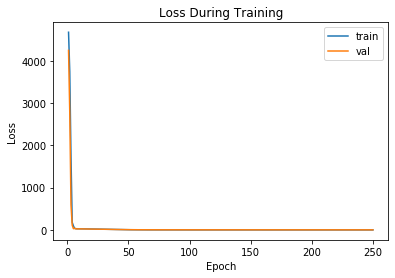

In [118]:
plot_model_history(history)

### Prediction and Plot

Forecast: [[77.17138 76.75825 73.81828 69.34598 66.81158 63.44577]]


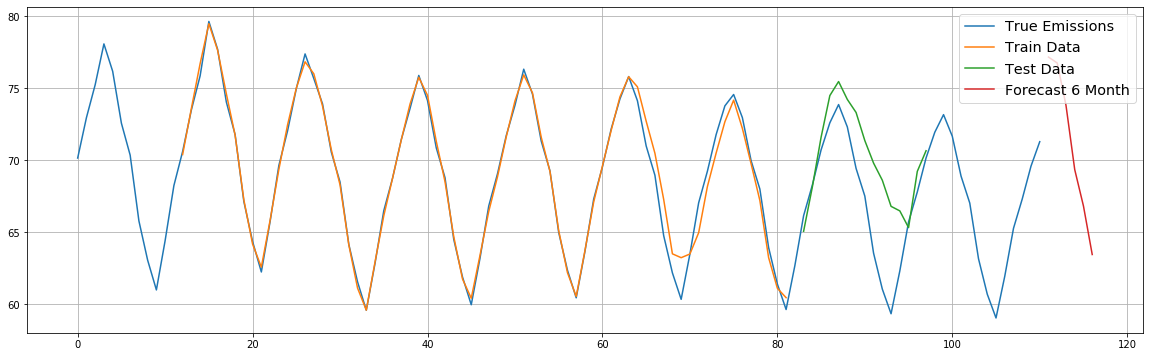

In [119]:
# Forecast predictions
forecastPlot = np.zeros((len(emission_data) + horizon))
forecastPlot[:] = np.nan

# Features
#X = np.zeros((1, look_back, feature_data.shape[1]))
X = np.zeros((1, look_back, trainX.shape[2]))
#X[0] = feature_data[len(feature_data)-look_back:, :]
X[0] = feature_data[len(feature_data)-look_back:, :trainX.shape[2]]
predict = model.predict(X)
forecastPlot[len(feature_data):len(feature_data)+horizon] = predict[:]

print(f"Forecast: {predict}")

# Plot baseline, training, test and forecast
plt.figure(figsize=(20,6))
line1 = plt.plot(emission_data[:], label='True Emissions')
line2 = plt.plot(trainPredictPlot[:], label='Train Data')
plt.plot(testPredictPlot[:], label='Test Data')
plt.plot(forecastPlot[:], label='Forecast 6 Month')
plt.legend(fontsize='x-large')
plt.grid()
plt.xticks()
plt.show()